## Strategy
How will Strategy module will be used:

It will take a:
- df (the start and the ending date will be provided within the dataframe)
- type of objective function to use ('Sharpe Ratio', 'Multiple', ... any metrics)


It will contain methods:
- that will perform dynamic universe selection
- that will contain the trading strategy (will take the parameters as input)
- that will optimize for the best parameters given the objective function (will call the trading strategy method)\
-> Make sure to enforce the use of discrete parameters (by using an integer space (not real))\
-> Use Bayesian Optimization 
- that will perform the walk forward analysis (from sklearn.model_selection import TimeSeriesSplit)

It will output the strategy return column, position, cumulative return, trades, sessions, cumulative session return.


======================================================

Practical Recommendations
Low-Dimensional Problems (<5 dimensions):

init_points: 5–10
n_iter: 10–30
Moderate-Dimensional Problems (5–10 dimensions):

init_points: 10–15
n_iter: 30–50
High-Dimensional Problems (>10 dimensions):

Bayesian optimization might struggle due to the curse of dimensionality. Consider alternatives like random search or evolutionary algorithms if dimensions are very high.

======================================================

The key is to perform separate walk-forward analysis for both the strategies and the rebalancing process

---

In [2]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from qgridnext import show_grid
from datetime import datetime, timedelta
import sys  
import os
import pandas_ta as ta
import sklearn as sk
import datetime as dt
from skopt.space import Integer, Real, Categorical

# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Data_Management'))) #We have a double .. as we are in the Strategy subfolder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Universe_Selection')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Signal_Generation')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Risk_Management')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Validation')))

# Import the modules
from data import Data
from calculations import Calculations, Metrics
from coarse import Coarse_1 as Coarse
from fine import Fine_1 as Fine
from entry_signal import Trend_Following, Mean_Reversion
from tail_risk import Stop_Loss, Take_Profit
from manage_trade import Manage_Trade
from position import Position
from testing import WFO
from stress_test import Stress_Test
from costs import Costs


Skipping category 'layer-1', already processed.
Skipping category 'depin', already processed.
Skipping category 'proof-of-work-pow', already processed.
Skipping category 'proof-of-stake-pos', already processed.
Skipping category 'meme-token', already processed.
Skipping category 'dog-themed-coins', already processed.
Skipping category 'eth-2-0-staking', already processed.
Skipping category 'non-fungible-tokens-nft', already processed.
Skipping category 'governance', already processed.
Skipping category 'artificial-intelligence', already processed.
Skipping category 'infrastructure', already processed.
Skipping category 'layer-2', already processed.
Skipping category 'zero-knowledge-zk', already processed.
Skipping category 'storage', already processed.
Skipping category 'oracle', already processed.
Skipping category 'bitcoin-fork', already processed.
Skipping category 'restaking', already processed.
Skipping category 'rollup', already processed.
Skipping category 'metaverse', already p

Importing all_data.csv file for all types of data

In [3]:
# Specify the relative or absolute path to the CSV file
file_path = r"C:\Users\yassi\OneDrive\Documents\GitHub\Portfolio_1\Technical_Portfolio\Data_Management\all_data.csv"

# Read the CSV file
all_data = pd.read_csv(file_path, index_col=['date', 'coin'], parse_dates=['date'])
all_data

close      creturns         high  \
date                coin                                               
2017-08-17 05:00:00 BTCUSDT   4315.320000  1.506209e-03  4328.690000   
                    ETHUSDT    303.100006  4.940270e-03   303.279999   
2017-08-17 06:00:00 BTCUSDT   4324.350000  3.151810e-06  4345.450000   
2017-08-17 07:00:00 BTCUSDT   4349.990000  1.868776e-08  4349.990000   
                    ETHUSDT    307.959991  8.617874e-05   307.959991   
...                                   ...           ...          ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.000000e+00     0.112400   
                    TRXUSDT      0.259400  0.000000e+00     0.259600   
                    VETUSDT      0.045760  0.000000e+00     0.045760   
                    WAXPUSDT     0.040910  0.000000e+00     0.040940   
                    XECUSDT      0.000035  0.000000e+00     0.000035   

                              log_return          low         open  \
date                coin                                             
2017-08-17 05:00:00 BTCUSDT    -6.498159  4291.370000  4308.830000   
                    ETHUSDT    -5.310335   300.000000   301.609985   
2017-08-17 06:00:00 BTCUSDT    -6.169374  4309.370000  4330.290000   
2017-08-17 07:00:00 BTCUSDT    -5.127863  4287.410000  4316.620000   
                    ETHUSDT    -4.048752   302.600006   302.679993   
...                                  ...          ...          ...   
2024-12-27 23:00:00 SYSUSDT    -5.632999     0.111100     0.111600   
                    TRXUSDT    -7.860292     0.258600     0.259400   
                    VETUSDT    -5.479996     0.045370     0.045580   
                    WAXPUSDT   -5.915972     0.040590     0.040770   
                    XECUSDT    -5.503282     0.000034     0.000034   

                                    price   returns        volume  \
date                coin                                            
2017-08-17 05:00:00 BTCUSDT   4315.320000  0.001506  2.323492e+01   
                    ETHUSDT    303.100006  0.004940  3.776725e+02   
2017-08-17 06:00:00 BTCUSDT   4324.350000  0.002093  7.229691e+00   
2017-08-17 07:00:00 BTCUSDT   4349.990000  0.005929  4.443249e+00   
                    ETHUSDT    307.959991  0.017444  7.547451e+02   
...                                   ...       ...           ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.003578  7.290790e+05   
                    TRXUSDT      0.259400  0.000386  1.499596e+07   
                    VETUSDT      0.045760  0.004169  1.004372e+07   
                    WAXPUSDT     0.040910  0.002696  1.056349e+06   
                    XECUSDT      0.000035  0.004073  1.147830e+09   

                              volume_in_dollars  
date                coin                         
2017-08-17 05:00:00 BTCUSDT        1.002661e+05  
                    ETHUSDT        1.144725e+05  
2017-08-17 06:00:00 BTCUSDT        3.126371e+04  
2017-08-17 07:00:00 BTCUSDT        1.932809e+04  
                    ETHUSDT        2.324313e+05  
...                                         ...  
2024-12-27 23:00:00 SYSUSDT        8.180266e+04  
                    TRXUSDT        3.889953e+06  
                    VETUSDT        4.596008e+05  
                    WAXPUSDT       4.321524e+04  
                    XECUSDT        3.961160e+04  

[956964 rows x 10 columns]

In [4]:
start_time = dt.datetime(2020, 1, 1)
end_time = dt.datetime(2021, 1, 1)
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'XRPUSDT']
data = Data(symbols, interval, start_time, end_time).df
data

close  creturns         high  log_return  \
date                coin                                                      
2020-01-01 01:00:00 ADAUSDT      0.03299  1.006406      0.03303    0.006386   
                    BNBUSDT     13.79950  1.007402     13.80000    0.007375   
                    BTCUSDT   7216.27000  1.005469   7230.00000    0.005454   
                    ETHUSDT    130.64000  1.013735    130.65000    0.013641   
                    XRPUSDT      0.19371  1.006390      0.19372    0.006370   
...                                  ...       ...          ...         ...   
2020-12-31 23:00:00 ADAUSDT      0.18134  5.532032      0.18255    0.008807   
                    BNBUSDT     37.35880  2.727298     37.42310    0.004338   
                    BTCUSDT  28923.63000  4.030033  29110.35000   -0.006108   
                    ETHUSDT    736.42000  5.714441    741.70000   -0.005498   
                    XRPUSDT      0.21959  1.140846      0.22562   -0.018991   

                                     low         open        price   returns  \
date                coin                                                       
2020-01-01 01:00:00 ADAUSDT      0.03276      0.03277      0.03299  0.006406   
                    BNBUSDT     13.69530     13.69810     13.79950  0.007402   
                    BTCUSDT   7175.71000   7176.47000   7216.27000  0.005469   
                    ETHUSDT    128.78000    128.87000    130.64000  0.013735   
                    XRPUSDT      0.19237      0.19243      0.19371  0.006390   
...                                  ...          ...          ...       ...   
2020-12-31 23:00:00 ADAUSDT      0.17848      0.17976      0.18134  0.008846   
                    BNBUSDT     37.07430     37.21130     37.35880  0.004347   
                    BTCUSDT  28780.00000  29100.83000  28923.63000 -0.006090   
                    ETHUSDT    731.83000    740.46000    736.42000 -0.005483   
                    XRPUSDT      0.21740      0.22376      0.21959 -0.018811   

                                   volume  volume_in_dollars  
date                coin                                      
2020-01-01 01:00:00 ADAUSDT  1.560752e+06       5.148920e+04  
                    BNBUSDT  5.379125e+04       7.422924e+05  
                    BTCUSDT  8.830526e+02       6.372346e+06  
                    ETHUSDT  1.134466e+04       1.482066e+06  
                    XRPUSDT  2.339976e+06       4.532768e+05  
...                                   ...                ...  
2020-12-31 23:00:00 ADAUSDT  1.717465e+07       3.114451e+06  
                    BNBUSDT  3.913231e+04       1.461936e+06  
                    BTCUSDT  1.976419e+03       5.716522e+07  
                    ETHUSDT  1.945008e+04       1.432343e+07  
                    XRPUSDT  4.654821e+07       1.022152e+07  

[43825 rows x 10 columns]

---

## Dynamic Universe Selection Strategy

current_universe = {}\
max_positions = 4
```pseudocode
for each row:
	for each coin in current_universe:
		If the current position of the coin == 0
			Remove it from current universe

	if len(universe) < max_positions:

		current coins = coins at the current index
		available_coins = current_coins - universe => All coins not in the universe

		filter = above_ema, volume_rank < 50 (could be optimized), std_rank < 4 (should be FINAL Constant),	 entry_signal.shift() == 1
		potential_coins = available coins with applied filter => Potenatial coins that could be added to the universe
		potential_coins = potential_coins.sort(based on std_rank)
	
		missing_positions = max_positions - len(current_universe)
		to_be_added = potential_coins[:missing_positions]

		current_universe = current_universe + to_be_added #Update the current universe

	for each coin in the current row:
		if coin is in universe:
			df[(time, coin), 'in_universe'] = True => mark it as part of the universe

	return df = df[df['in_universe']]

```



In [5]:
def create_test_df(num_times: int = 5, num_coins: int = 10):
    """Creates a multi-index DataFrame for testing."""
    times = pd.to_datetime(['2024-01-01'] + [pd.Timestamp('2024-01-01') + pd.Timedelta(days=i) for i in range(1, num_times)])
    coins = [f"Coin_{i}" for i in range(num_coins)]
    index = pd.MultiIndex.from_product([times, coins], names=['time', 'coin'])
    
    df = pd.DataFrame(index=index)
    df['above_ema'] = np.random.choice([True, False], size=len(df))
    df['volume_rank'] = np.random.randint(1, 100, size=len(df))
    df['std_rank'] = np.random.randint(1, 10, size=len(df))
    df['entry_signal'] = np.random.randint(0, 2, size=len(df)) # 0 or 1
    df['position'] = np.random.randint(0, 2, size=len(df))
    return df

# Example usage to create a test DataFrame:
test_df = create_test_df(num_times=4, num_coins=8)
test_df.head()

above_ema  volume_rank  std_rank  entry_signal  position
time       coin                                                            
2024-01-01 Coin_0       True           14         9             1         1
           Coin_1      False            6         5             0         1
           Coin_2       True           64         5             1         1
           Coin_3      False           94         5             1         0
           Coin_4       True           49         5             1         0

In [6]:
import pandas as pd
import numpy as np
from typing import Set, List
import pandas as pd
from typing import List


def update_universe(df: pd.DataFrame, max_positions: int = 4, low_freq = '1d') -> pd.Series:
    """
    Updates a DataFrame to track a dynamic universe of coins.
    Should include the dataframe with the lower frequency data. (daily, weekly, etc.)
    Assumes a stacked dataframe
    """
    current_universe = set()
    df['in_universe'] = False
    df['position'] = np.where(df['position'] < 0.1, 0, df['position']) #Since when optimizing, min_pos can never be 0, thus we put a threshold of 0.1 to indicate a non position    


    for time_index in df.index.get_level_values(0).unique():
        # Remove coins that are no longer in the universe *for this time index*
        coins_to_remove = []
        
        
        for coin in current_universe:
            if (time_index, coin) in df.index and df.loc[(time_index, coin), 'position'] == 0: 
                coins_to_remove.append(coin)
                df.loc[(time_index, coin), 'in_universe'] = False
        current_universe.difference_update(coins_to_remove) #use difference_update for set manipulation


        current_coins = df.loc[time_index].index
        available_coins = set(current_coins) - current_universe

        if len(current_universe) < max_positions and available_coins:
            temp_df = df.loc[(time_index, list(available_coins)), :].copy()

            # The shift was the main source of the bug. It was shifting across coins,
            # which is incorrect. We should not shift at all in this context.
            # The intention was likely to use the *previous* time slice data.
            # This is handled later.

            filter_condition = (
                (temp_df['above_ema']) &
                (temp_df['volume_rank'] < 50) &
                (temp_df['std_rank'] < 10) &
                (temp_df['entry_signal'] == 1)
            )

            potential_coins_df = temp_df[filter_condition]

            if not potential_coins_df.empty:
                potential_coins_df = potential_coins_df.sort_values(by='std_rank')
                potential_coins = set(potential_coins_df.index.get_level_values(1))
                missing_positions = max_positions - len(current_universe)
                to_be_added: List[str] = list(potential_coins)[:missing_positions]
                current_universe.update(to_be_added)

        df.loc[(time_index, list(current_universe)), 'in_universe'] = True
    
    df = df.unstack()
    df['in_universe'] = df['in_universe'].shift(periods = 1, freq = low_freq)
    df = df.stack(future_stack= True)
    return df['in_universe'], current_universe

test_df['in_universe'], current_universe = update_universe(test_df)

print(current_universe)
test_df

{'Coin_4', 'Coin_2', 'Coin_6', 'Coin_7'}


above_ema  volume_rank  std_rank  entry_signal  position  \
time       coin                                                               
2024-01-01 Coin_0       True           14         9             1         1   
           Coin_1      False            6         5             0         1   
           Coin_2       True           64         5             1         1   
           Coin_3      False           94         5             1         0   
           Coin_4       True           49         5             1         0   
           Coin_5       True           88         2             1         0   
           Coin_6       True           43         7             1         1   
           Coin_7       True           29         2             0         0   
2024-01-02 Coin_0       True           58         2             0         0   
           Coin_1      False           25         5             1         0   
           Coin_2      False           28         4             0         0   
           Coin_3      False           93         4             1         1   
           Coin_4       True           31         5             0         1   
           Coin_5      False           95         4             0         1   
           Coin_6      False           45         6             0         0   
           Coin_7       True           54         1             0         1   
2024-01-03 Coin_0      False           12         3             1         0   
           Coin_1       True           74         3             1         1   
           Coin_2       True            3         6             0         0   
           Coin_3       True           57         4             1         1   
           Coin_4       True           22         7             1         0   
           Coin_5       True           91         4             0         0   
           Coin_6      False           37         8             1         1   
           Coin_7       True           46         8             1         0   
2024-01-04 Coin_0       True           48         2             0         0   
           Coin_1      False           35         1             1         0   
           Coin_2       True           13         1             1         0   
           Coin_3      False           46         3             0         1   
           Coin_4      False           27         9             0         1   
           Coin_5      False           62         6             0         0   
           Coin_6       True           17         1             1         0   
           Coin_7      False           74         6             0         1   

                  in_universe  
time       coin                
2024-01-01 Coin_0         NaN  
           Coin_1         NaN  
           Coin_2         NaN  
           Coin_3         NaN  
           Coin_4         NaN  
           Coin_5         NaN  
           Coin_6         NaN  
           Coin_7         NaN  
2024-01-02 Coin_0        True  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4        True  
           Coin_5       False  
           Coin_6        True  
           Coin_7       False  
2024-01-03 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4        True  
           Coin_5       False  
           Coin_6       False  
           Coin_7       False  
2024-01-04 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4        True  
           Coin_5       False  
           Coin_6       False  
           Coin_7        True

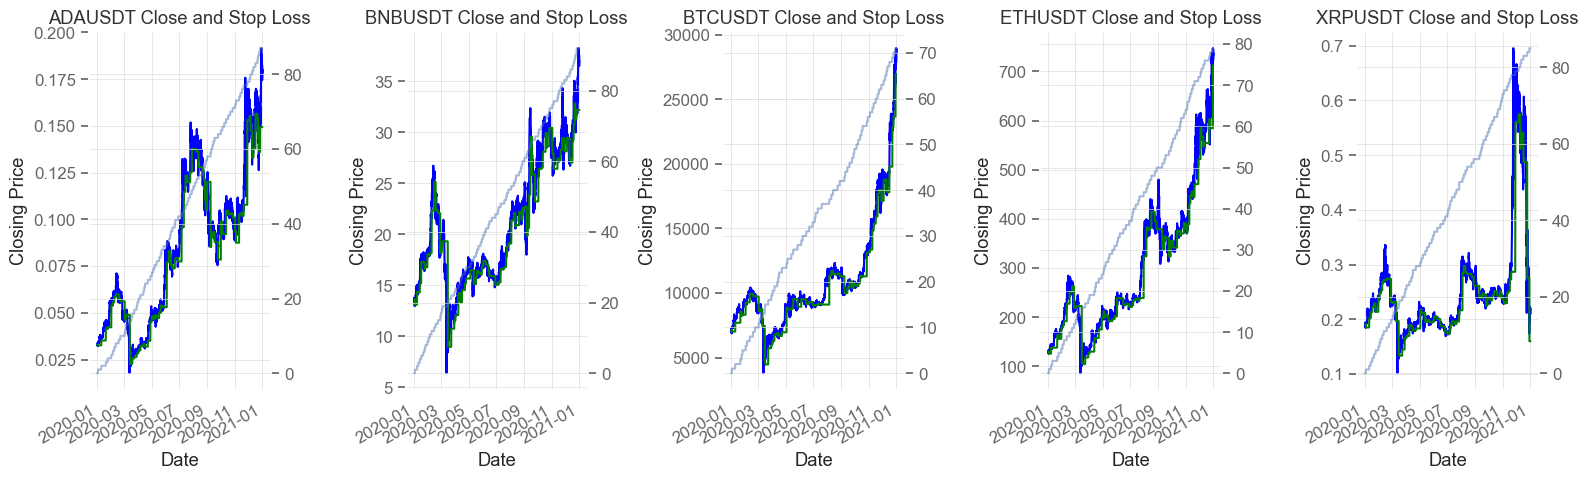

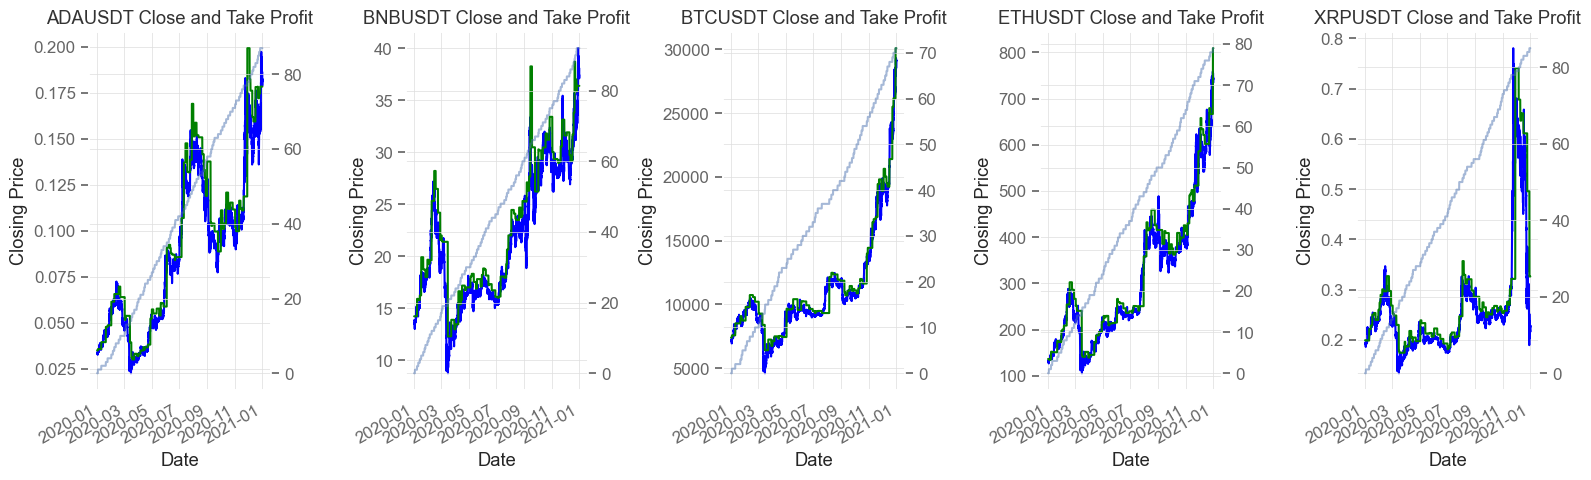

In [7]:
###### To Optimize ######
#All parameters:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling
low_freq_index = 1 #The index of the lowest frequency for the resampling
low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
max_dollar_allocation = 10000
std_window = 2
mean_window = 2
ema_window = 2
high_freq_index = 3 #The index of the highest frequency for the resampling
high_freq = all_frequency[high_freq_index] #The highest frequency for the resampling
str_length = 10
str_mult = 3
_min_pos = 0.1
_max_pos = 1
sl_type = 'atr'
sl_ind_length = 14
sl_ind_mult = 3
sl_signal_only = True
fixed_sl = True
tp_type = 'rr'
tp_mult = 2
tp_ind_length = 0
tp_signal_only = True
fixed_tp = True
max_perc_risk = 0.01




#Downsample the data
cal = Calculations()
#Generate a signal
tf = Trend_Following()

_df = tf.supertrend_signals(data, str_length, str_mult)

pos = Position(_df, _min_pos, _max_pos)
_df = pos.initialize_position()
sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
_df = sl.apply_stop_loss(fixed_sl, plot = True)
tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
_df = tp.apply_take_profit(fixed_tp, plot = True)

_df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
_df = pos.calculate_position(_df)

mt = Manage_Trade(_df)
_df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)

#########################

_df = cal.update_all(_df)



In [8]:
_df['trades'].value_counts()

trades
 0.0    43072
 0.9      343
-0.9      340
Name: count, dtype: int64

In [9]:
_df['session'].value_counts()

session
62.0     739
51.0     611
72.0     582
32.0     557
18.0     535
        ... 
139.0     64
141.0     61
143.0     59
144.0     55
145.0     52
Name: count, Length: 146, dtype: int64

In [10]:
_df['position'].value_counts()  

position
0.1    24727
1.0    19023
Name: count, dtype: int64

In [11]:
#Calculate transaction costs on strategy returns
costs = Costs(_df, maker = 0.25, taker = 0.40)
_df = costs.apply_fees() #Applies fees on strategy returns, appears on cumulative returns when applied 

In [12]:
_df['trade_costs'].value_counts()

trade_costs
-0.00000    43072
 0.00225      343
 0.00360      340
Name: count, dtype: int64

In [13]:
df = cal.downsample(_df, low_freq)

In [14]:
#Perform coarse analysis and filtering
coarse = Coarse()
df = coarse.volume_flag(df, max_dollar_allocation)
df = coarse.sort_by_volume(df)
df = coarse.sort_by_std(df, std_window, mean_window)
fine = Fine()
df = fine.above_ema(df, ema_window)

In [15]:
#apply update_univers
df['in_universe'], current_universe = update_universe(df)

In [16]:
df.dropna()

close  creturns         high  log_return  \
date                                                                          
2020-01-02 15:00:00 ADAUSDT      0.03317  1.011897      0.03329   -0.003311   
                    BNBUSDT     13.40440  0.978559     13.43610   -0.000082   
                    BTCUSDT   7130.98000  0.993585   7152.00000   -0.000646   
                    ETHUSDT    129.59000  1.005587    129.80000    0.001699   
                    XRPUSDT      0.19054  0.989921      0.19131   -0.002516   
...                                  ...       ...          ...         ...   
2020-12-31 23:00:00 ADAUSDT      0.18134  5.532032      0.18255    0.008807   
                    BNBUSDT     37.35880  2.727298     37.42310    0.004338   
                    BTCUSDT  28923.63000  4.030033  29110.35000   -0.006108   
                    ETHUSDT    736.42000  5.714441    741.70000   -0.005498   
                    XRPUSDT      0.21959  1.140846      0.22562   -0.018991   

                                     low         open        price   returns  \
date                                                                           
2020-01-02 15:00:00 ADAUSDT      0.03315      0.03329      0.03317 -0.003305   
                    BNBUSDT     13.35500     13.40190     13.40440 -0.000082   
                    BTCUSDT   7120.00000   7135.59000   7130.98000 -0.000646   
                    ETHUSDT    129.36000    129.37000    129.59000  0.001701   
                    XRPUSDT      0.19030      0.19102      0.19054 -0.002513   
...                                  ...          ...          ...       ...   
2020-12-31 23:00:00 ADAUSDT      0.17848      0.17976      0.18134  0.008846   
                    BNBUSDT     37.07430     37.21130     37.35880  0.004347   
                    BTCUSDT  28780.00000  29100.83000  28923.63000 -0.006090   
                    ETHUSDT    731.83000    740.46000    736.42000 -0.005483   
                    XRPUSDT      0.21740      0.22376      0.21959 -0.018811   

                                   volume  volume_in_dollars  ...  \
date                                                          ...   
2020-01-02 15:00:00 ADAUSDT  3.811639e+05       1.264321e+04  ...   
                    BNBUSDT  3.195121e+04       4.282868e+05  ...   
                    BTCUSDT  8.624297e+02       6.149969e+06  ...   
                    ETHUSDT  5.352620e+03       6.936461e+05  ...   
                    XRPUSDT  1.301272e+06       2.479443e+05  ...   
...                                   ...                ...  ...   
2020-12-31 23:00:00 ADAUSDT  1.717465e+07       3.114451e+06  ...   
                    BNBUSDT  3.913231e+04       1.461936e+06  ...   
                    BTCUSDT  1.976419e+03       5.716522e+07  ...   
                    ETHUSDT  1.945008e+04       1.432343e+07  ...   
                    XRPUSDT  4.654821e+07       1.022152e+07  ...   

                               htf_close    htf_volume  htf_volume_in_dollars  \
date                                                                            
2020-01-02 15:00:00 ADAUSDT      0.03269  4.282646e+07           1.405664e+06   
                    BNBUSDT     13.01050  9.711907e+05           1.298722e+07   
                    BTCUSDT   6965.71000  3.195148e+04           2.258280e+08   
                    ETHUSDT    127.19000  2.137571e+05           2.749587e+07   
                    XRPUSDT      0.18750  4.791211e+07           9.081044e+06   
...                                  ...           ...                    ...   
2020-12-31 23:00:00 ADAUSDT      0.18134  4.476726e+08           8.077478e+07   
                    BNBUSDT     37.35880  1.887716e+06           7.047616e+07   
                    BTCUSDT  28923.63000  7.550851e+04           2.176310e+09   
                    ETHUSDT    736.42000  8.633756e+05           6.384437e+08   
                    XRPUSDT      0.21959  1.391877e+09           3.022339e+08   

              

<Axes: xlabel='date,None'>

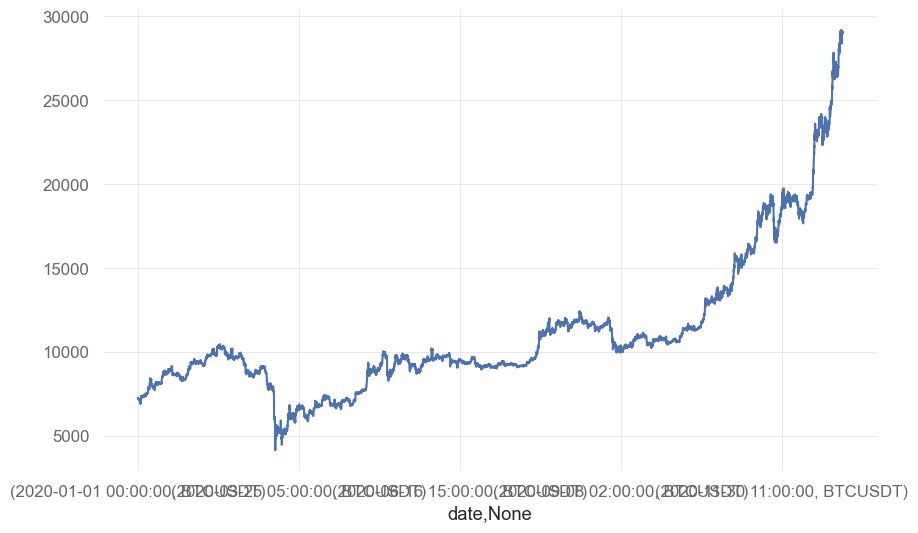

In [17]:
df.loc[(slice(None), 'BTCUSDT'), 'close'].plot()


In [18]:
df.dropna(inplace = True)

In [19]:
df = df[df['in_universe']]

#### Trading Strategy

In [20]:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling 

In [26]:
def trading_strategy(
        data,
        params = None,
        ###### To Optimize ######
        std_window = 20,
        mean_window = 20,
        ema_window = 20,
        hourly_lookback = 1,
        daily_lookback= 1,
        _min_pos = 0, #Has to be >= 0
        _max_pos = 1, #Has to be > 0
        sl_ind_length = 14,
        sl_ind_mult = 3,
        tp_mult = 2,
        ptp_mult = 1,
        ptp_exit_percent = 0.5,
        ###### Constants ######
        low_freq_index = 1, #The index of the lowest frequency for the resampling
        high_freq_index = 3, #The index of the highest frequency for the resampling
        max_perc_risk = 0.01,
        max_dollar_allocation = 10000,
        sl_type = 'atr',
        tp_type = 'rr',
        sl_signal_only = True,
        tp_signal_only = True,
        ptp_signal_only = True,
        tp_ind_length = 0,
        fixed_sl = True,
        fixed_tp = True,
        maker = 0.25,
        taker = 0.40,
        max_universe = 4
        ):
    
    if params is not None:
        if isinstance(params, list):
            std_window = params[0]
            mean_window = params[1]
            ema_window = params[2]
            hourly_lookback = params[3]
            daily_lookback = params[4]
            _min_pos = params[5]
            _max_pos = params[6]
            sl_ind_length = params[7]
            sl_ind_mult = params[8]
            tp_mult = params[9]
            ptp_mult = params[10]
            ptp_exit_percent = params[11]
        if isinstance(params, dict):
            std_window = params['std_window']
            mean_window = params['mean_window']
            ema_window = params['ema_window']
            hourly_lookback = params['str_length']
            daily_lookback = params['str_mult']
            _min_pos = params['_min_pos']
            _max_pos = params['_max_pos']
            sl_ind_length = params['sl_ind_length']
            sl_ind_mult = params['sl_ind_mult']
            tp_mult = params['tp_mult']
            ptp_mult = params['ptp_mult']
            ptp_exit_percent = params['ptp_exit_percent']
        


    if high_freq_index > low_freq_index:
        low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
        high_freq = all_frequency[high_freq_index], #The highest frequency for the resampling
            #Generally not going to be used since we are not calling the data inside the function
    
    #########################
    
    cal = Calculations()
    mr = Mean_Reversion()
    #Generate a signal
    _df = mr.last_days_low(data.copy(), hourly_lookback, daily_lookback)

    pos = Position(_df, _min_pos, _max_pos)
    _df = pos.initialize_position()
    sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
    _df = sl.apply_stop_loss(fixed_sl, plot = False)
    tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
    _df = tp.apply_take_profit(fixed_tp, plot = False)
    ptp = Take_Profit(_df, tp_type, ptp_mult, ptp_signal_only, exit_percent = ptp_exit_percent)
    _df = ptp.apply_take_profit(fixed_tp, plot = False)

    _df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
    _df = pos.calculate_position(_df)

    mt = Manage_Trade(_df)
    _df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)
    
    _df = cal.update_all(_df)

    #########################
    
    #Calculate transaction costs on strategy returns
    costs = Costs(_df, maker = maker, taker = taker)
    df = costs.apply_fees() #Applies fees on strategy returns, appears on cumulative returns when applied 

    #########################
    
    #Downsample the data
    df = cal.downsample(df, low_freq)

    #Perform coarse analysis and filtering
    coarse = Coarse()
    df = coarse.volume_flag(df, max_dollar_allocation)
    df = coarse.sort_by_volume(df)
    df = coarse.sort_by_std(df, std_window, mean_window)
    fine = Fine()
    df = fine.above_ema(df, ema_window)

    #apply update_univers
    df['in_universe'], current_universe = update_universe(df, max_positions = max_universe)

    df.dropna(inplace = True)

    df = df[df['in_universe']]
    
    return df



In [27]:
sample_strategy = trading_strategy(data)
'strategy' in sample_strategy.columns

True

In [28]:
sample_strategy

,,close,creturns,high,log_return,low,open,price,returns,volume,volume_in_dollars,...,htf_close,htf_volume,htf_volume_in_dollars,volume_flag,volume_rank,htf_std_values,std_rank,ema_20,above_ema,in_universe
date,coin,,,,,,,,,,,,,,,,,,,,,
2020-01-17 17:00:00,XRPUSDT,0.23845,1.238830,0.23850,0.012916,0.23481,0.23539,0.238162,0.013000,8001190.4,1.907884e+06,...,0.23921,214368960.7,5.056137e+07,1,2.0,0.013194,3.0,0.233358,1,True
2020-01-17 18:00:00,XRPUSDT,0.24228,1.258728,0.24289,0.015934,0.23812,0.23845,0.242280,0.016062,20191664.5,4.892036e+06,...,0.23921,214368960.7,5.056137e+07,1,2.0,0.009564,3.0,0.234208,1,True
2020-01-17 19:00:00,XRPUSDT,0.23742,1.233479,0.24453,-0.020263,0.23149,0.24220,0.237420,-0.020059,25768794.6,6.118027e+06,...,0.23921,214368960.7,5.056137e+07,1,2.0,0.000000,3.0,0.234514,1,True
2020-01-17 20:00:00,XRPUSDT,0.23708,1.231712,0.23957,-0.001433,0.23609,0.23742,0.237080,-0.001432,9394550.3,2.227260e+06,...,0.23921,214368960.7,5.056137e+07,1,2.0,0.000000,3.0,0.234758,1,True
2020-01-17 21:00:00,XRPUSDT,0.24009,1.247350,0.24010,0.012616,0.23626,0.23708,0.240090,0.012696,5551759.5,1.332922e+06,...,0.23921,214368960.7,5.056137e+07,1,2.0,0.000000,3.0,0.235266,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22 06:00:00,ADAUSDT,0.15515,4.733069,0.15643,-0.002253,0.15415,0.15553,0.155150,-0.002251,21031572.7,3.263049e+06,...,0.15646,472974503.2,7.380258e+07,1,2.0,0.011689,5.0,0.155985,0,True
2020-12-22 07:00:00,ADAUSDT,0.15264,4.656498,0.15626,-0.016310,0.15179,0.15524,0.152640,-0.016178,21969538.3,3.353430e+06,...,0.15646,472974503.2,7.380258e+07,1,2.0,0.011991,5.0,0.155666,0,True
2020-12-22 08:00:00,ADAUSDT,0.15217,4.642160,0.15329,-0.003084,0.14879,0.15261,0.152170,-0.003079,32799737.6,4.991136e+06,...,0.15646,472974503.2,7.380258e+07,1,2.0,0.012163,5.0,0.155333,0,True


In [29]:
# Define parameter space for optimization
param_space = {
    'std_window': Integer(5, 30),
    'mean_window': Integer(5, 30),
    'ema_window': Integer(5, 100),
    'hourly_lookback': Integer(1, 3),
    'daily_lookback': Integer(1, 3),
    '_min_pos': Real(0, 0.5),
    '_max_pos': Real(0, 1),
    'sl_ind_length': Integer(5, 50),
    'sl_ind_mult': Real(0.5, 5),
    'tp_mult': Integer(2, 7),
    'ptp_mult': Real(1, 2),
    'ptp_exit_percent': Real(0.1, 1)
}

In [30]:
wfo = WFO(data, 
            trading_strategy, 
            param_space, 
            train_size=2000, 
            test_size=2000, 
            step_size=2000, 
            optimize_fn="gp", 
            objective='multiple', 
            opt_freq='custom')

all_performance, all_results = wfo.walk_forward_optimization()

0
1.000038859104612
1.0589296170207685
0
1.0908555317551107
0
0
0
0
0
{'std_window': 19, 'mean_window': 6, 'ema_window': 85, 'hourly_lookback': 2, 'daily_lookback': 2, '_min_pos': 0.4633294328968972, '_max_pos': 0.727271995856421, 'sl_ind_length': 20, 'sl_ind_mult': 3.066997884824298, 'tp_mult': 5, 'ptp_mult': 1.9611720243493493, 'ptp_exit_percent': 0.8600804638103364}
[19, 6, 85, 2, 2, 0.4633294328968972, 0.727271995856421, 20, 3.066997884824298, 5, 1.9611720243493493, 0.8600804638103364]
Out-of-sample performance: 1.0306859531978383
1.0048303973587416
0.9994360718481714
1.076452192505509
1.0294081809468294
1.0306859531978383
1.0135645761996193
1.054378349667225
1.0643701821242288
0
1.0130015566691515
{'std_window': 7, 'mean_window': 20, 'ema_window': 41, 'hourly_lookback': 3, 'daily_lookback': 2, '_min_pos': 0.4299702033681604, '_max_pos': 0.6803075385877798, 'sl_ind_length': 25, 'sl_ind_mult': 0.5596923252193994, 'tp_mult': 7, 'ptp_mult': 1.5632882178455394, 'ptp_exit_percent': 0.44

In [31]:
np.mean(all_performance)

0.5085290126495225

In [32]:
all_results

close  creturns      high  log_return  \
date                coin                                                
2020-01-31 04:00:00 BNBUSDT   18.6000  1.357853   18.8482   -0.013261   
                    ETHUSDT  182.2900  1.414526  183.6700   -0.006180   
2020-01-31 05:00:00 BNBUSDT   18.3946  1.342858   18.6375   -0.011104   
                    ETHUSDT  181.2600  1.406534  182.7300   -0.005666   
2020-01-31 06:00:00 BNBUSDT   18.4766  1.348844   18.5208    0.004448   
...                               ...       ...       ...         ...   
2020-11-26 16:00:00 ETHUSDT  497.3800  3.859548  512.2700   -0.021127   
2020-11-26 17:00:00 ETHUSDT  495.3900  3.844106  497.4800   -0.004009   
2020-11-26 18:00:00 ETHUSDT  494.5200  3.837355  502.8500   -0.001758   
2020-11-26 19:00:00 ETHUSDT  500.1400  3.880965  504.1100    0.011300   
2020-11-26 20:00:00 ETHUSDT  522.4500  4.054086  523.3800    0.043641   

                                  low      open     price   returns  \
date                coin                                              
2020-01-31 04:00:00 BNBUSDT   18.5263   18.8482   18.6000 -0.013174   
                    ETHUSDT  181.7000  183.4200  182.2900 -0.006161   
2020-01-31 05:00:00 BNBUSDT   18.3200   18.6017   18.3946 -0.011043   
                    ETHUSDT  180.5200  182.2700  181.2600 -0.005650   
2020-01-31 06:00:00 BNBUSDT   18.3527   18.3903   18.4766  0.004458   
...                               ...       ...       ...       ...   
2020-11-26 16:00:00 ETHUSDT  494.2400  508.0000  497.3800 -0.020906   
2020-11-26 17:00:00 ETHUSDT  481.0000  497.4800  495.3900 -0.004001   
2020-11-26 18:00:00 ETHUSDT  492.0800  495.3300  494.5200 -0.001756   
2020-11-26 19:00:00 ETHUSDT  487.7500  494.4600  500.1400  0.011365   
2020-11-26 20:00:00 ETHUSDT  499.9200  500.1600  522.4500  0.044608   

                                   volume  volume_in_dollars  ...      ema_85  \
date                coin                                      ...               
2020-01-31 04:00:00 BNBUSDT  125974.26000       2.343121e+06  ...   18.016622   
                    ETHUSDT   15827.63950       2.885220e+06  ...  175.542690   
2020-01-31 05:00:00 BNBUSDT  132887.45000       2.444411e+06  ...   18.025412   
                    ETHUSDT   18830.26470       3.413174e+06  ...  175.675651   
2020-01-31 06:00:00 BNBUSDT   56857.75000       1.050538e+06  ...   18.035905   
...                                   ...                ...  ...         ...   
2020-11-26 16:00:00 ETHUSDT  104034.48805       5.174467e+07  ...         NaN   
2020-11-26 17:00:00 ETHUSDT  178714.93413       8.853359e+07  ...         NaN   
2020-11-26 18:00:00 ETHUSDT   62846.31155       3.107876e+07  ...         NaN   
2020-11-26 19:00:00 ETHUSDT   79790.90046       3.990662e+07  ...         NaN   
2020-11-26 20:00:00 ETHUSDT  102183.13043       5.338558e+07  ...         NaN   

                             above_ema  in_universe  ema_41      ema_79 trade  \
date                coin                                                        
2020-01-31 04:00:00 BNBUSDT          1         True     NaN         NaN   NaN   
                    ETHUSDT          1         True     NaN         NaN   NaN   
2020-01-31 05:00:00 BNBUSDT          1         True     NaN         NaN   NaN   
                    ETHUSDT          1         True     NaN         NaN   NaN   
2020-01-31 06:00:00 BNBUSDT          1         True     NaN         NaN   NaN   
...                                ...          ...     ...         ...   ...   
2020-11-26 16:00:00 ETHUSDT          0         True     NaN  562.042692   NaN   
2020-11-26 17:00:00 ETHUSDT          0         True     NaN  560.376374   NaN   
2020-11-26 18:00:00 ETHUSDT          0         True     NaN  558.729965   NaN   
2020-11-26 19:00:00 ETHUSDT          0         True     NaN  557.265216   NaN   
2020-11-26 20:00:00 ETHUSDT          0         True     NaN  556.394835   NaN   

                            ema_28  ema_61  ema_73

In [33]:
import quantstats_lumi as qs

In [34]:
qs.stats.sharpe(all_results['strategy'].apply(np.exp) - 1)

0.2710858894197395

<Axes: xlabel='date,coin'>

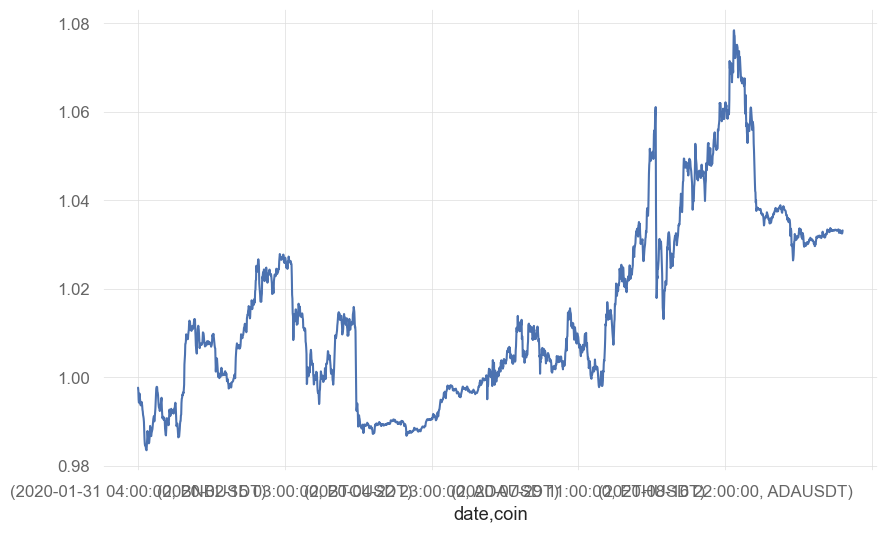

In [35]:
all_results['cstrategy'] = creturns = (all_results['strategy'] * (1/4)).cumsum().apply(np.exp)
creturns.plot()

In [ ]:
def optimize_sizes(data, trading_strategy, param_space):
    best_performance = -np.inf
    for train_size in range(1000, 3001, 500):  # Adjust the step size as needed
        for test_size in range(1000, 3001, 500):
            for step_size in range(1000, 3001, 500):
                wfo = WFO(data, 
                        trading_strategy, 
                        param_space, 
                        train_size=train_size, 
                        test_size=test_size, 
                        step_size=step_size, 
                        optimize_fn="gp", 
                        objective='sharpe', 
                        opt_freq='custom')
                print(f"Train size: {train_size}, Test size: {test_size}, Step size: {step_size}")
                all_performance, all_results = wfo.walk_forward_optimization()
                if np.mean(all_performance) > best_performance:
                    best_performance = np.mean(all_performance)
                    best_train_size = train_size
                    best_test_size = test_size
                    best_step_size = step_size
                    best_results = all_results
                print(f"Mean performance: {np.mean(all_performance)}")

    return best_train_size, best_test_size, best_step_size, best_results, best_performance

optimize_sizes(data, trading_strategy, param_space)


---

Stress Testing using Block Bootstrapping

In [36]:
strategy = all_results['strategy']

In [37]:
num_simulations = 100
confidence_level = 0.95

In [38]:
stress_test = Stress_Test(strategy, num_simulations, confidence_level)

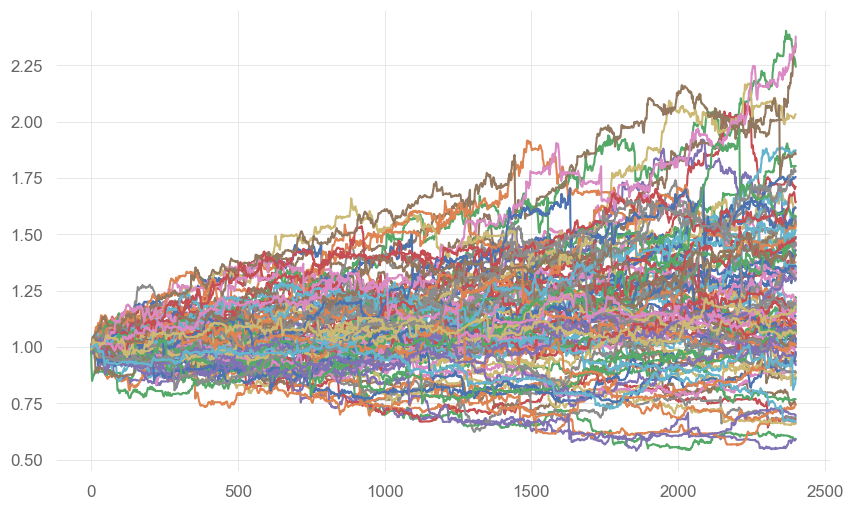

In [39]:
sims = stress_test.block_bootstrap(20)

In [50]:
metrics_df = stress_test.metrics_df_fnct(sims)
score = stress_test.score_strategy(metrics_df)

In [51]:
metrics_df.describe()

,max_drawdown,avg_drawdown,avg_drawdown_duration,sharpe_ratio,var,cvar
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.250624,-0.095512,50.736342,0.018244,-0.005928,0.000068
std,0.095979,0.065640,33.340223,0.026789,0.000318,0.000124
min,-0.565148,-0.321065,2.000000,-0.044181,-0.007030,-0.000223
25%,-0.297987,-0.112399,31.547581,0.003162,-0.006081,0.000004
50%,-0.228282,-0.075343,40.379630,0.016786,-0.005955,0.000063
75%,-0.174822,-0.050348,62.253378,0.037092,-0.005765,0.000156
max,-0.120560,-0.025874,186.416667,0.083164,-0.005224,0.000360


In [52]:
score

51.808078745591814